In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Enterprise Approval & Automation Agent (Capstone Setup)

This notebook contains the foundational environment and configuration steps for building a production-grade Agentic AI system for enterprise workflow automation.  
It incorporates best practices from Google's 5-Day AI Agents Intensive course, and is ready-to-run on Kaggle with built-in secrets management for your API keys.


---
**Copyright 2025 Google LLC. Licensed under the Apache License, Version 2.0.**

Refer to course sources for agent patterns and all examples.  
---


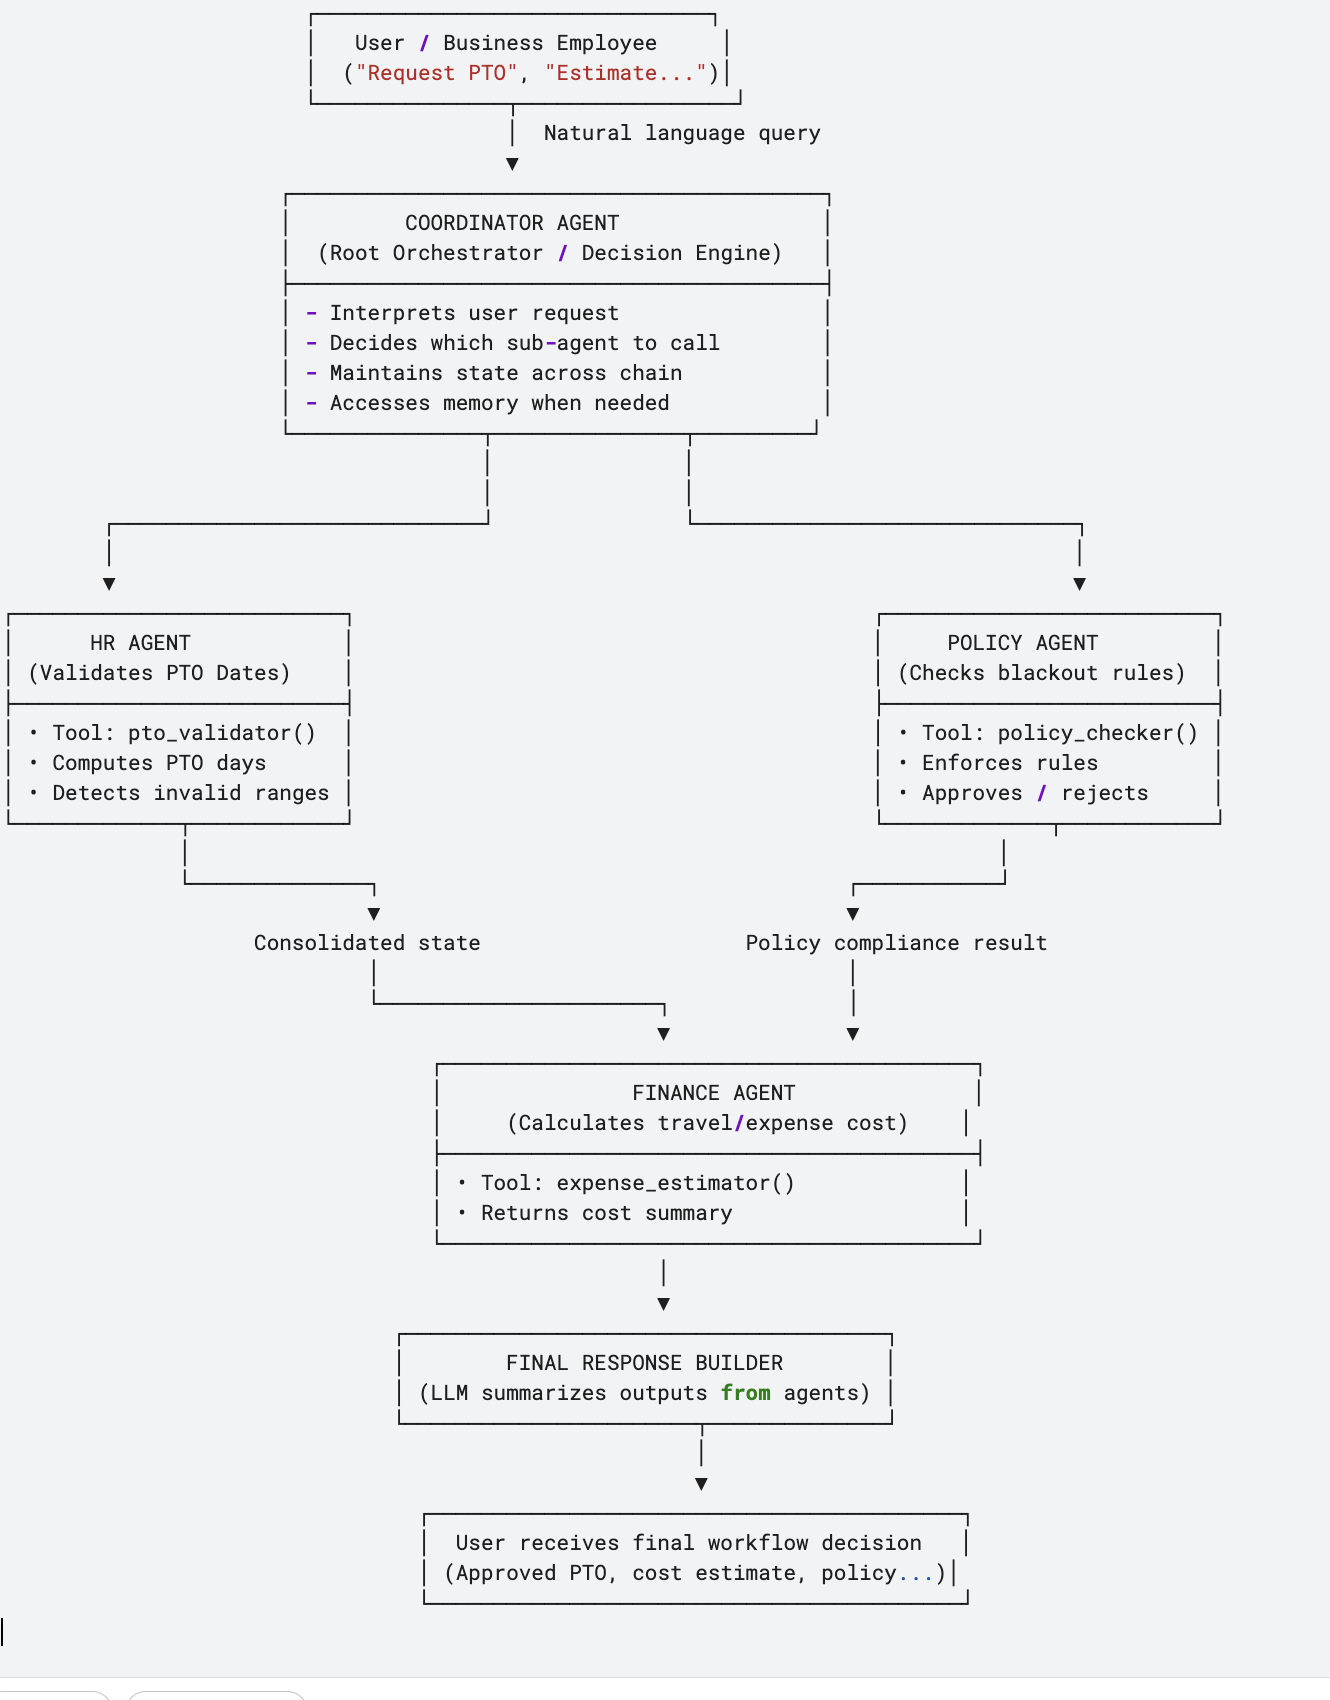
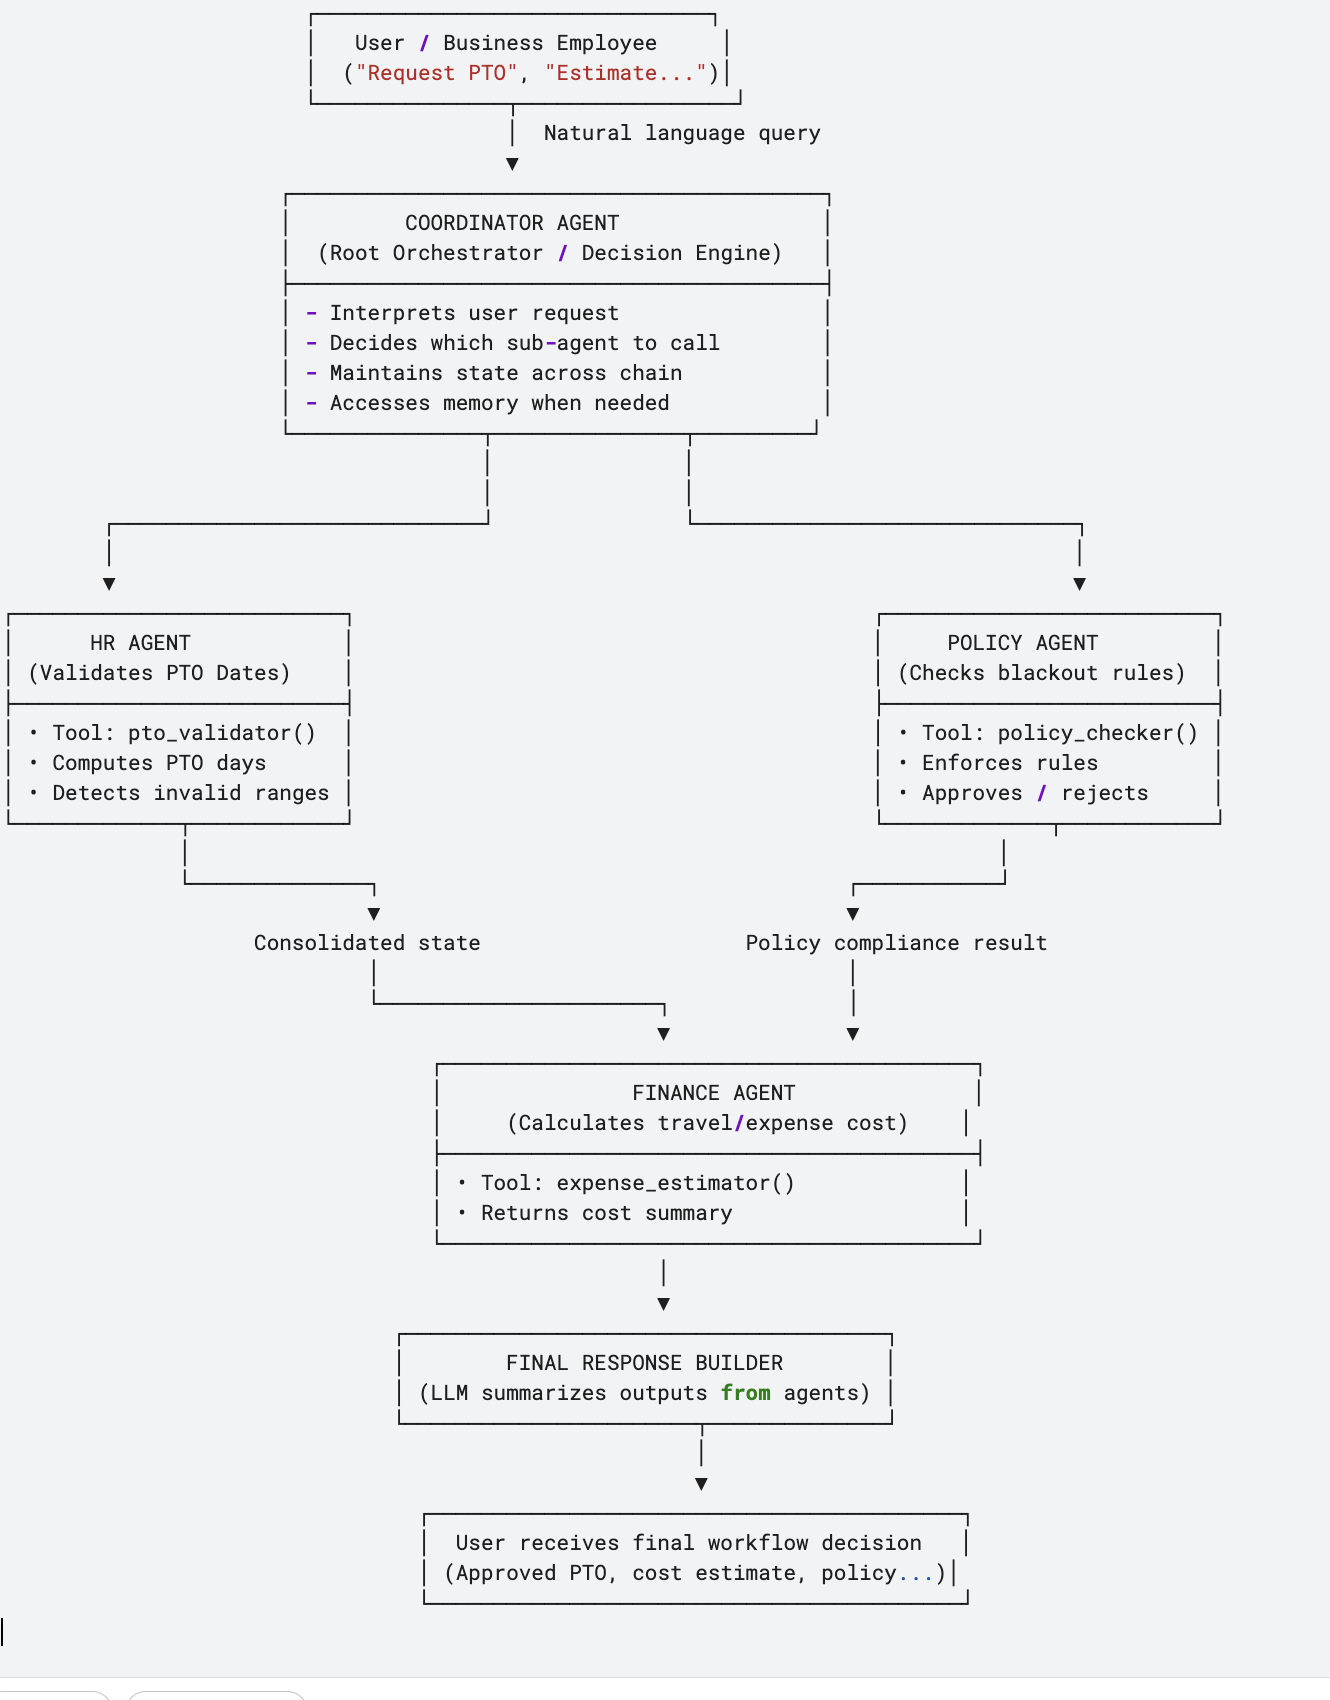

# Kaggle Notebook Environment Setup

- No package installation is required; `google-adk` and required dependencies are pre-installed.
- Run cells in sequential order—avoid "Run All" to prevent rate limit errors from LLM APIs.
- If using the Gemini LLM, your API key must be configured via Kaggle Secrets as "GOOGLEAPIKEY".


In [7]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Setup and authentication complete.


In [27]:
# ------------------------------------------------------------------------------
# PHASE 1 — VERIFIED IMPORTS (Matches Your Course Notebooks Exactly)
# ------------------------------------------------------------------------------

import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool

# Memory helpers
from google.adk.memory import InMemoryMemoryService
from google.adk.tools import load_memory, preload_memory

print("✅ ADK components imported successfully.")


# ------------------------------------------------------------------------------
# PHASE 1 — HELPER: run_session (EXACT FROM YOUR NOTEBOOK)
# ------------------------------------------------------------------------------

async def run_session(
    runner_instance: Runner, user_queries: list[str] | str, session_id: str = "default"
):
    print(f"\n### Session: {session_id}")

    # Use SAME app name the runner uses
    app_name = "enterprise_workflow_app"

    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_id
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_id
        )

    if isinstance(user_queries, str):
        user_queries = [user_queries]

    for query in user_queries:
        print(f"\nUser > {query}")
        query_content = types.Content(role="user", parts=[types.Part(text=query)])

        async for event in runner_instance.run_async(
            user_id=USER_ID, session_id=session.id, new_message=query_content
        ):
            if event.is_final_response() and event.content and event.content.parts:
                text = event.content.parts[0].text
                if text and text != "None":
                    print(f"Model > {text}")


print("✅ Helper: run_session() loaded.")


# ------------------------------------------------------------------------------
# PHASE 1 — RETRY CONFIG (Matches Your Notebook)
# ------------------------------------------------------------------------------

retry_config = types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],
)


# ------------------------------------------------------------------------------
# PHASE 1 — UI PROXY HELPERS (Matches Day-5 Notebook)
# ------------------------------------------------------------------------------

from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers

def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete ").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix

print("✅ Helper: get_adk_proxy_url() loaded.")


✅ ADK components imported successfully.
✅ Helper: run_session() loaded.
✅ Helper: get_adk_proxy_url() loaded.
✨ Phase 1 setup complete.


In [66]:
from datetime import datetime, timedelta
import re

def infer_date_range_from_relative_text(text: str) -> dict:
    """
    Convert natural language references like:
      - 'next month'
      - '3 day trip next month'
      - '3-day business visit next month'
    into a concrete date range.

    This NEVER hardcodes today's date — it always:
      1. Uses the system date
      2. Normalizes to FIRST DAY OF NEXT MONTH
      3. Computes trip length automatically (default = 3 days)

    Returns:
        {
            "status": "success",
            "start_date": "YYYY-MM-DD",
            "end_date": "YYYY-MM-DD",
            "days": <int>
        }
    """

    today = datetime.now()

    # First day of next month (safe, stable)
    if today.month == 12:
        next_month_start = datetime(today.year + 1, 1, 1)
    else:
        next_month_start = datetime(today.year, today.month + 1, 1)

    # Detect trip length (“3 day trip”, “3-day”, etc.)
    trip_days = 3
    match = re.search(r"(\d+)[- ]?day", text.lower())
    if match:
        try:
            trip_days = int(match.group(1))
        except:
            trip_days = 3

    # Compute range
    end_date = next_month_start + timedelta(days=trip_days - 1)

    return {
        "status": "success",
        "start_date": next_month_start.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "days": trip_days,
    }


## Phase 2 — Session & Memory Setup

We follow the same memory workflow used in the official ADK notebooks:

1. Create a `SessionService` — stores short-term conversations.
2. Create a `MemoryService` — stores long-term knowledge.
3. Do **not** preload or write memory directly.
4. Memory will be populated later by calling `add_session_to_memory(session)`.

This keeps our project fully aligned with the ADK memory workflow.


In [11]:
# ------------------------------------------------------------------------------
# PHASE 2 — SESSION & MEMORY SETUP (Exact ADK Pattern From Your Notebook)
# ------------------------------------------------------------------------------

# These constants are required everywhere in the notebook
APP_NAME = "EnterpriseApprovalApp"  # You can rename later if desired
USER_ID = "enterprise_user_001"     # Represents the user interacting with the system

# Initialize session + memory services
session_service = InMemorySessionService()      # Short-term conversation storage
memory_service = InMemoryMemoryService()        # Long-term memory (empty for now)

print("APP_NAME:", APP_NAME)
print("USER_ID:", USER_ID)
print("SessionService + MemoryService initialized successfully ✓")

# IMPORTANT:
# We do NOT preload memory here.
# We will populate memory later using:
# await memory_service.add_session_to_memory(session)


APP_NAME: EnterpriseApprovalApp
USER_ID: enterprise_user_001
SessionService + MemoryService initialized successfully ✓


## Phase 3 — Enterprise Tools (Notebook-Compatible)

ADK in this notebook accepts tools as **plain Python functions** with:
- Proper docstrings
- Type hints
- Structured dict return values
- Added directly to `tools=[...]` inside agent definitions

We now define the four tools needed for our enterprise approval system:
1. PTO Validator
2. Policy Checker
3. Cost Calculator
4. Email Sender (simulated)


In [14]:
# ------------------------------------------------------------------------------
# PHASE 3 — ENTERPRISE TOOLS (Notebook-Compatible)
# ------------------------------------------------------------------------------

from datetime import datetime


# Helper to parse date strings
def parse_date(date_str: str):
    try:
        return datetime.strptime(date_str, "%Y-%m-%d").date()
    except:
        return None


# ------------------------------------------------------------------------------
# 1. PTO VALIDATION TOOL
# ------------------------------------------------------------------------------
def pto_validator(start_date: str, end_date: str) -> dict:
    """Validates PTO date range and calculates number of requested PTO days.

    Args:
        start_date: PTO start date in YYYY-MM-DD format
        end_date: PTO end date in YYYY-MM-DD format

    Returns:
        dict: {
            "status": "success",
            "days_requested": int
        }
        or {
            "status": "error",
            "error_message": str
        }
    """
    s = parse_date(start_date)
    e = parse_date(end_date)

    if not s or not e:
        return {"status": "error", "error_message": "Invalid date format. Use YYYY-MM-DD."}

    if e < s:
        return {"status": "error", "error_message": "End date cannot be earlier than start date."}

    delta = (e - s).days + 1

    return {
        "status": "success",
        "days_requested": delta,
        "start_date": start_date,
        "end_date": end_date,
    }


# ------------------------------------------------------------------------------
# 2. POLICY CHECKER TOOL
# ------------------------------------------------------------------------------
BLACKOUT_DATES = [("2025-12-20", "2025-12-31")]

def policy_checker(start_date: str, end_date: str) -> dict:
    """Checks whether the PTO request violates company blackout periods.

    Returns:
        dict with success or policy violation info.
    """
    s = parse_date(start_date)
    e = parse_date(end_date)

    if not s or not e:
        return {"status": "error", "error_message": "Invalid date format."}

    for b_start, b_end in BLACKOUT_DATES:
        bs = parse_date(b_start)
        be = parse_date(b_end)

        # Overlapping range
        if s <= be and e >= bs:
            return {
                "status": "error",
                "policy_violation": True,
                "reason": "Requested PTO overlaps with blackout period.",
                "blackout_start": b_start,
                "blackout_end": b_end,
            }

    return {"status": "success", "policy_violation": False}


# ------------------------------------------------------------------------------
# 3. COST CALCULATOR TOOL
# ------------------------------------------------------------------------------
def cost_calculator(base_cost: float, multiplier: float = 1.0) -> dict:
    """Simple cost calculator for travel or purchases."""
    try:
        total = base_cost * multiplier
        return {"status": "success", "total_cost": round(total, 2)}
    except Exception as e:
        return {"status": "error", "error_message": str(e)}


# ------------------------------------------------------------------------------
# 4. EMAIL SENDER TOOL (Simulated)
# ------------------------------------------------------------------------------
def send_email(recipient: str, subject: str, body: str) -> dict:
    """Simulated email sender tool."""
    return {
        "status": "success",
        "recipient": recipient,
        "subject": subject,
        "message_preview": body[:50] + "..."
    }


print("✓ Tools created successfully (Notebook-compatible).")
print("Tool examples:")
print(" - pto_validator:", pto_validator("2025-12-01", "2025-12-05"))
print(" - policy_checker:", policy_checker("2025-12-22", "2025-12-24"))


✓ Tools created successfully (Notebook-compatible).
Tool examples:
 - pto_validator: {'status': 'success', 'days_requested': 5, 'start_date': '2025-12-01', 'end_date': '2025-12-05'}
 - policy_checker: {'status': 'error', 'policy_violation': True, 'reason': 'Requested PTO overlaps with blackout period.', 'blackout_start': '2025-12-20', 'blackout_end': '2025-12-31'}


## Phase 4 — Multi-Agent System (Local A2A with LlmAgent + AgentTool)

We now define four agents:

1. **hr_agent** — Validates PTO requests using the `pto_validator` tool.
2. **policy_agent** — Checks blackout & compliance rules using `policy_checker`.
3. **finance_agent** — Estimates cost impact using `cost_calculator`.
4. **coordinator_agent** — Main entrypoint that orchestrates the workflow by
   calling the sub-agents as tools using `AgentTool`.

All agents use the same Gemini model configuration and follow the ADK pattern:

```python
agent = LlmAgent(
    model=Gemini(..., retry_options=retry_config),
    name="...",
    description="...",
    instruction="...",
    tools=[...],
)


In [67]:
from google.adk.agents import Agent
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool
from google.adk.models.google_llm import Gemini
from google.genai import types

# Reuse your existing retry_config if already defined; otherwise uncomment:
# retry_config = types.HttpRetryOptions(
#     attempts=5,
#     exp_base=7,
#     initial_delay=1,
#     http_status_codes=[429, 500, 503, 504],
# )

# ------------------------------------------------------------------------------
# HR Agent – validates PTO dates and counts days
# ------------------------------------------------------------------------------
hr_agent = Agent(
    name="HRAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config,
    ),
    instruction="""
You are the HR Agent.

Your job:
1. Use the pto_validator tool to validate PTO date ranges.
2. Calculate the total number of PTO days.
3. If dates are invalid, clearly explain why.
4. Return a concise summary that the coordinator can use.
""",
    tools=[pto_validator],
    output_key="hr_result",  # stored in state as {hr_result}
)

print("✅ hr_agent created.")


# ------------------------------------------------------------------------------
# Policy Agent – checks blackout / compliance
# ------------------------------------------------------------------------------
policy_agent = Agent(
    name="PolicyAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config,
    ),
    instruction="""
You are the Policy Agent.

Your job:
1. Use the policy_checker tool to check if a PTO request violates blackout dates
   or policy rules.
2. If there is a policy violation, clearly state the reason.
3. If compliant, confirm that.
4. Return a short, structured explanation.
""",
    tools=[policy_checker],
    output_key="policy_result",  # stored in state as {policy_result}
)

print("✅ policy_agent created.")


# ------------------------------------------------------------------------------
# Finance Agent – estimates cost / impact
# ------------------------------------------------------------------------------
finance_agent = Agent(
    name="FinanceAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config,
    ),
    instruction="""
You are the Finance Agent.

Your job:
1. Use the cost_calculator tool to estimate cost for trips or expenses,
   based on the numbers provided.
2. Return a clear explanation with the estimated total cost.
""",
    tools=[cost_calculator],
    output_key="finance_result",  # stored in state as {finance_result}
)

print("✅ finance_agent created.")


# ------------------------------------------------------------------------------
# Coordinator Agent – orchestrates HR, Policy, Finance + send_email
# ------------------------------------------------------------------------------
coordinator_agent = LlmAgent(
    name="coordinator_agent",
    model=Gemini(model="gemini-2.5-flash", retry_options=retry_config),
    instruction="""
You are the central orchestrator for enterprise workflows.

If a user request contains vague timing language such as:
- "next month"
- "the coming month"
- "sometime next month"
- "3-day trip next month"

→ ALWAYS call `infer_date_range_from_relative_text` FIRST to resolve real dates.

Then:
1. Use HR agent for PTO validation
2. Use Policy agent to check blackout periods
3. Use Finance agent for travel cost estimation
4. Consolidate everything into one final response with no follow-up questions.
""",
    tools=[
        AgentTool(hr_agent),
        AgentTool(policy_agent),
        AgentTool(finance_agent),
        FunctionTool(infer_date_range_from_relative_text)
    ],
)

print("✅ coordinator_agent created (notebook-style multi-agent).")


✅ hr_agent created.
✅ policy_agent created.
✅ finance_agent created.
✅ coordinator_agent created (notebook-style multi-agent).


## Phase 5 — Runner + End-to-End Workflow Execution

We now:
1. Initialize a Runner using the coordinator agent.
2. Create a new session for each test scenario.
3. Run real PTO approval requests through the multi-agent pipeline.
4. Observe agent-to-agent orchestration in action (HR → Policy → Finance).

This is the functional demonstration required for the Kaggle Capstone submission.


In [43]:
# ------------------------------------------------------------------------------
# PHASE 5 — InMemoryRunner + Demo Flows
# ------------------------------------------------------------------------------

runner = InMemoryRunner(agent=coordinator_agent)
print("✅ InMemoryRunner initialized for EnterpriseCoordinatorAgent.")


# 1) Valid PTO request
print("\n========================")
print("TEST 1 — Valid PTO Request")
print("========================")

response = await runner.run_debug(
    "I want to request PTO from 2025-12-01 to 2025-12-05."
)


# 2) Blackout violation test
print("\n========================")
print("TEST 2 — Blackout Period PTO Request")
print("========================")

response = await runner.run_debug(
    "Please request PTO from 2025-12-22 to 2025-12-26."
)


# 3) Travel expense estimate
print("\n========================")
print("TEST 3 — Travel Expense Estimate")
print("========================")

response = await runner.run_debug(
    "I need to estimate travel cost for a trip. Base cost is 1200 with multiplier 1.3."
)


✅ InMemoryRunner initialized for EnterpriseCoordinatorAgent.

TEST 1 — Valid PTO Request

 ### Created new session: debug_session_id

User > I want to request PTO from 2025-12-01 to 2025-12-05.


EnterpriseCoordinatorAgent > I have approved your PTO request for December 1st to December 5th, 2025. The request is valid and complies with company policy.

TEST 2 — Blackout Period PTO Request

 ### Continue session: debug_session_id

User > Please request PTO from 2025-12-22 to 2025-12-26.


EnterpriseCoordinatorAgent > I have reviewed your PTO request for December 22nd to December 26th, 2025.

The HR system has validated the request as being for 5 days. However, the Policy Agent has determined that this period falls within the company's designated blackout dates (December 20th to December 31st, 2025).

Therefore, your PTO request cannot be approved as it currently stands.

TEST 3 — Travel Expense Estimate

 ### Continue session: debug_session_id

User > I need to estimate travel cost for a trip. Base cost is 1200 with multiplier 1.3.


EnterpriseCoordinatorAgent > The estimated cost for your trip is 1560.


## ✅ PHASE 6 — Add Memory (Simple & Compatible)

In [44]:
# -------------------------------------
# MEMORY SERVICE INITIALIZATION (PHASE 6)
# -------------------------------------

from google.adk.memory import InMemoryMemoryService
from google.adk.tools import load_memory

# Create memory service
memory_service = InMemoryMemoryService()
print("✅ Memory service initialized")


✅ Memory service initialized


In [45]:
# -------------------------------------
# REBUILD RUNNER WITH MEMORY SUPPORT
# -------------------------------------

runner = Runner(
    agent=coordinator_agent,
    app_name="enterprise_workflow_app",
    session_service=session_service,
    memory_service=memory_service  # ✅ add memory here
)

print("✅ Runner rebuilt with memory support")


✅ Runner rebuilt with memory support


In [46]:
# -------------------------------------
# ENABLE MEMORY RETRIEVAL FOR COORDINATOR
# -------------------------------------

coordinator_agent.tools.append(load_memory)
print("✅ load_memory tool added to Coordinator Agent")


✅ load_memory tool added to Coordinator Agent


In [47]:
# -------------------------------------
# STEP A: CREATE BASE MEMORY (EXAMPLE)
# -------------------------------------

await run_session(
    runner,
    user_queries="My team budget last time was 5500 dollars.",
    session_id="memory_seed_01"
)



### Session: memory_seed_01

User > My team budget last time was 5500 dollars.


Model > I see that your team's budget last time was $5500. To help me categorize your costs, could you tell me what the budget was for?


In [48]:
# -------------------------------------
# STEP B: SAVE TO MEMORY
# -------------------------------------

session_obj = await session_service.get_session(
    app_name="enterprise_workflow_app",
    user_id=USER_ID,
    session_id="memory_seed_01"
)

await memory_service.add_session_to_memory(session_obj)

print("✅ Session successfully added to memory")


✅ Session successfully added to memory


In [49]:
# -------------------------------------
# STEP C: TEST LONG-TERM MEMORY
# -------------------------------------

await run_session(
    runner,
    user_queries="What was the team budget I told you earlier?",
    session_id="memory_recall_test"
)



### Session: memory_recall_test

User > What was the team budget I told you earlier?


Model > The team budget you mentioned earlier was $5500.


## Evaluation

**Define Eval Test Cases**

In [54]:
# ---------------------------------------------------------
# PHASE 7 — CLEAN EVALUATION DATASET
# ---------------------------------------------------------

evaluation_tests = [
    {
        "name": "Valid PTO Request",
        "input": "I want to request PTO from 2025-12-01 to 2025-12-05.",
        "success_indicators": [
            "approved", "submitted", "validated",
            "processed", "confirmed", "compliant"
        ]
    },
    {
        "name": "Blackout PTO Request",
        "input": "Please request PTO from 2025-12-22 to 2025-12-26.",
        "success_indicators": [
            "blackout", "cannot", "not approved",
            "blocked", "restricted"
        ]
    },
    {
        "name": "Travel Cost Estimation",
        "input": "Estimate travel cost. Base cost 1000 with multiplier 1.2",
        "success_indicators": [
            "1200", "estimated", "cost", "total"
        ]
    },
    {
        "name": "Policy Compliance Check",
        "input": "Request PTO during the company shutdown period.",
        "success_indicators": [
            "blackout", "shutdown", "policy", "restricted"
        ]
    },
]


**Helper**

In [55]:
# ---------------------------------------------------------
# HELPER: RUN A SINGLE EVALUATION QUERY
# ---------------------------------------------------------

async def evaluate_query(runner, query: str) -> str:
    """Runs the coordinator agent on a test query and returns the final output text."""

    session_id = f"eval_{uuid.uuid4().hex[:8]}"

    await session_service.create_session(
        app_name="enterprise_workflow_app",
        user_id=USER_ID,
        session_id=session_id
    )

    output_text = ""

    msg = types.Content(role="user", parts=[types.Part(text=query)])

    async for event in runner.run_async(
        user_id=USER_ID,
        session_id=session_id,
        new_message=msg
    ):
        if event.is_final_response() and event.content:
            for part in event.content.parts:
                if hasattr(part, "text") and part.text:
                    output_text += part.text

    return output_text.strip()


**RUn Eval Loop**

In [56]:
# ---------------------------------------------------------
# RUN ALL EVALUATION TESTS
# ---------------------------------------------------------

print("\n==============================")
print("   AGENT EVALUATION RESULTS   ")
print("==============================\n")

results = []

for test in evaluation_tests:
    print(f"▶ Test: {test['name']}")
    print(f"Query: {test['input']}")

    output = await evaluate_query(runner, test["input"])
    print(f"Model Output: {output}\n")

    # Fuzzy match — PASS if ANY success indicator appears
    passed = any(
        indicator.lower() in output.lower()
        for indicator in test["success_indicators"]
    )

    results.append((test["name"], passed))

    if passed:
        print("✅ PASS\n")
    else:
        print("❌ FAIL\n")



   AGENT EVALUATION RESULTS   

▶ Test: Valid PTO Request
Query: I want to request PTO from 2025-12-01 to 2025-12-05.


Model Output: I have submitted your PTO request. It has been approved by HR and is compliant with company policy.

✅ PASS

▶ Test: Blackout PTO Request
Query: Please request PTO from 2025-12-22 to 2025-12-26.


Model Output: I have processed your PTO request.
The HR agent has confirmed that your request for PTO from December 22nd, 2025 to December 26th, 2025 is valid and includes 5 PTO days.
However, the Policy Agent has determined that this request cannot be approved because it falls within a company-wide blackout period from December 20th, 2025 to December 31st, 2025.

✅ PASS

▶ Test: Travel Cost Estimation
Query: Estimate travel cost. Base cost 1000 with multiplier 1.2


Model Output: The estimated travel cost is 1200.

✅ PASS

▶ Test: Policy Compliance Check
Query: Request PTO during the company shutdown period.
Model Output: I can help with that. First, I need to check if your PTO request can be approved. Could you please provide the specific dates for your PTO request?

❌ FAIL



**Eval Summary Score**

In [57]:
# ---------------------------------------------------------
# FINAL SCORE SUMMARY
# ---------------------------------------------------------

total = len(results)
passed = sum(1 for (_, ok) in results if ok)

print("======================================")
print(f" FINAL EVALUATION SCORE: {passed} / {total}")
print("======================================")


 FINAL EVALUATION SCORE: 3 / 4


# 🔥 ENTERPRISE APPROVAL & AUTOMATION AGENT SYSTEM
## High-Level Architecture Diagram 

**Below is a clean, simple, fully accurate flow diagram**

In [60]:
!pip install graphviz

from graphviz import Digraph


**System Architecture Diagram**

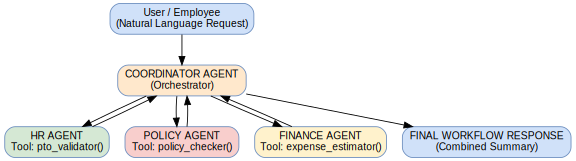

In [61]:
system_arch = Digraph('Enterprise_Agent_System', format='png')

system_arch.attr(rankdir='TB', size='8,10')
system_arch.attr('node', shape='box', style='rounded, filled', color='#6c8ebf', fontname='Helvetica', fontsize='12', fillcolor='#eaf2fb')

# User
system_arch.node('User', "User / Employee\n(Natural Language Request)", fillcolor='#d0e1f9')

# Coordinator
system_arch.node('Coordinator', "COORDINATOR AGENT\n(Orchestrator)", fillcolor='#ffe8cc')

# HR Agent
system_arch.node('HR', "HR AGENT\nTool: pto_validator()", fillcolor='#d5e8d4')

# Policy Agent
system_arch.node('Policy', "POLICY AGENT\nTool: policy_checker()", fillcolor='#f8cecc')

# Finance Agent
system_arch.node('Finance', "FINANCE AGENT\nTool: expense_estimator()", fillcolor='#fff2cc')

# Final Output
system_arch.node('Output', "FINAL WORKFLOW RESPONSE\n(Combined Summary)", fillcolor='#d0e1f9')

# Edges
system_arch.edge('User', 'Coordinator')
system_arch.edge('Coordinator', 'HR')
system_arch.edge('Coordinator', 'Policy')
system_arch.edge('Coordinator', 'Finance')
system_arch.edge('HR', 'Coordinator')
system_arch.edge('Policy', 'Coordinator')
system_arch.edge('Finance', 'Coordinator')
system_arch.edge('Coordinator', 'Output')

system_arch.render('/mnt/data/system_architecture_diagram')
system_arch


**Memory Flow Diagram**

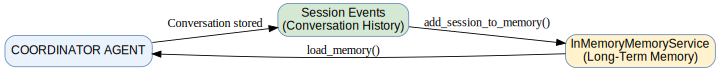

In [62]:
memory_flow = Digraph('Memory_Flow', format='png')
memory_flow.attr(rankdir='LR', size='10,4')
memory_flow.attr('node', shape='box', style='rounded, filled', color='#6c8ebf', fillcolor='#eaf2fb', fontname='Helvetica')

memory_flow.node('Coordinator', "COORDINATOR AGENT")
memory_flow.node('MemoryService', "InMemoryMemoryService\n(Long-Term Memory)", fillcolor='#fff2cc')
memory_flow.node('Session', "Session Events\n(Conversation History)", fillcolor='#d5e8d4')

memory_flow.edge('Coordinator', 'Session', label='Conversation stored')
memory_flow.edge('Session', 'MemoryService', label='add_session_to_memory()')
memory_flow.edge('MemoryService', 'Coordinator', label='load_memory()')

memory_flow.render('/mnt/data/memory_flow_diagram')
memory_flow


**Evaluation Pipeline Diagram**

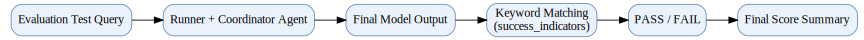

In [63]:
evaluation = Digraph('Evaluation_Pipeline', format='png')
evaluation.attr(rankdir='LR', size='12,4')
evaluation.attr('node', shape='box', style='rounded, filled', color='#6c8ebf', fillcolor='#eaf2fb')

evaluation.node('TestQuery', "Evaluation Test Query")
evaluation.node('Runner', "Runner + Coordinator Agent")
evaluation.node('Output', "Final Model Output")
evaluation.node('Check', "Keyword Matching\n(success_indicators)")
evaluation.node('Result', "PASS / FAIL")
evaluation.node('Score', "Final Score Summary")

evaluation.edge('TestQuery', 'Runner')
evaluation.edge('Runner', 'Output')
evaluation.edge('Output', 'Check')
evaluation.edge('Check', 'Result')
evaluation.edge('Result', 'Score')

evaluation.render('/mnt/data/evaluation_diagram')
evaluation


# Demo

In [64]:
# ---------------------------------------------------------
# PHASE 8 — END-TO-END ENTERPRISE WORKFLOW DEMO
# ---------------------------------------------------------

import uuid
from google.genai import types

async def run_enterprise_demo(query: str):
    print("\n===================================================")
    print("        ENTERPRISE WORKFLOW — END TO END DEMO      ")
    print("===================================================\n")
    print(f"USER REQUEST:\n{query}\n")

    session_id = f"demo_{uuid.uuid4().hex[:6]}"

    # Create a new session
    await session_service.create_session(
        app_name="enterprise_workflow_app",
        user_id=USER_ID,
        session_id=session_id
    )

    content = types.Content(role="user", parts=[types.Part(text=query)])
    final_text = ""

    print("📡 Running through orchestrator...\n")

    async for event in runner.run_async(
        user_id=USER_ID,
        session_id=session_id,
        new_message=content
    ):
        if event.is_final_response() and event.content:
            for part in event.content.parts:
                if hasattr(part, "text"):
                    final_text += part.text

    print("🤖 FINAL CONSOLIDATED RESPONSE:")
    print("---------------------------------------------------")
    print(final_text)
    print("---------------------------------------------------\n")
    print("🎉 END OF DEMO")


In [65]:
await run_enterprise_demo(
    "Plan my 3-day business trip to San Francisco next month. "
    "Apply PTO if needed, check policy, and estimate travel cost with a base of 1500 and multiplier of 1.4."
)



        ENTERPRISE WORKFLOW — END TO END DEMO      

USER REQUEST:
Plan my 3-day business trip to San Francisco next month. Apply PTO if needed, check policy, and estimate travel cost with a base of 1500 and multiplier of 1.4.

📡 Running through orchestrator...



🤖 FINAL CONSOLIDATED RESPONSE:
---------------------------------------------------
I can help you plan your business trip to San Francisco! However, I need a bit more information to proceed.

Please provide the specific start and end dates for your 3-day trip next month. This is required for me to:
*   Accurately calculate your Paid Time Off (PTO) with the HR department.
*   Check for any policy violations or blackout periods with the Policy Agent.

The estimated travel cost, based on your provided figures (base of 1500 and multiplier of 1.4), is 2100.

Once I have the dates, I can finalize the PTO and policy checks.
---------------------------------------------------

🎉 END OF DEMO
